In [3]:
# load packages
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import sklearn

%matplotlib inline

import pandas
import pickle
import pydot

Using TensorFlow backend.
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\tensorflow\python\framewo

In [4]:
# import the data
data = pandas.read_pickle('raw_processed.pkl')

# make a short version for better viewing
dataShort = data.iloc[0:10,19:46].copy()

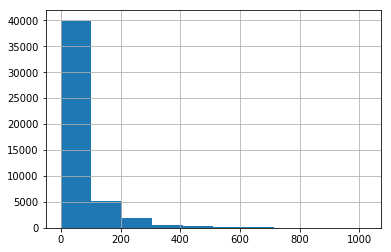

In [5]:
data.closest_pos.hist()

In [6]:
# set the number of adjacent soundings to use
adSoundings=1;

# get the line numbers, find the time difference between adjacent rows, and set a threshold for two points to be considered 
# part of the same sounding
lineNumbers=np.unique(data["LINE_NO"])
timeDiff=np.diff(data["TIMESTAMP"])
timeDiffMask=timeDiff<5e-6

# iterate through the line numbers
for line in lineNumbers:
    
# this is for debugging
#if 1==1:
#    line=lineNumbers[0]

    # make a mask for the rows in the big DF that are for this line number
    rowIndex=data["LINE_NO"]==line
    
    # get just the current rows
    currData=data.loc[rowIndex,:]
    currData.reset_index(drop=True, inplace=True)
    
    # make an array of the time differences
    timeDiff=np.diff(currData["TIMESTAMP"])

    # if the first time difference is large, drop the first row, this throws a warning
    if timeDiff[0]>1e-5:
        currData.drop([0], inplace=True)
        currData.reset_index(drop=True, inplace=True)
    
    # set the number of pairs in this line and make some arrays with large numbers for the HM and LM data
    numberPairs=np.int(len(currData.index)/2)
    currDataLM=np.ones((numberPairs,1+adSoundings*2,37))*9000
    currDataHM=np.ones((numberPairs,1+adSoundings*2,37))*9000
    currLabelsLM=np.zeros((numberPairs,1))
    currLabelsHM=np.zeros((numberPairs,1))
    
    # check to see if the first row is LM or HM, set the indexing
    if np.mean(currData.loc[0,'DBDT_Ch1GT1':'DBDT_Ch1GT28'])>9990:
        hmFirst=1
    else:
        hmFirst=0
               
    # iterate through the number of pairs
    for i in range(numberPairs):
        if hmFirst==1:
            if adSoundings==1:
                hmIndex=[(i-1)*2,i*2,(i+1)*2]
                lmIndex=[(i-1)*2+1,i*2+1,(i+1)*2+1]
            elif adSoundings==2:
                hmIndex=[(i-2)*2,(i-1)*2,i*2,(i+1)*2,(i+2)*2]
                lmIndex=[(i-2)*2+1,(i-1)*2+1,i*2+1,(i+1)*2+1,(i+2)*2+1]
        else:
            if adSoundings==1:
                lmIndex=[(i-1)*2,i*2,(i+1)*2]
                hmIndex=[(i-1)*2+1,i*2+1,(i+1)*2+1]
            elif adSoundings==2:
                hmIndex=[(i-2)*2,(i-1)*2,i*2,(i+1)*2,(i+2)*2]
                lmIndex=[(i-2)*2+1,(i-1)*2+1,i*2+1,(i+1)*2+1,(i+2)*2+1]
        
        # for the first pair, leave the sounding in position 0 alone as it doesnt exist, do the same for the last pair but 
        # for the sounding in position 2
        # TODO: modify this to work for 2 or 3 or 4 or 5 adjacent soundings
        if i==0:
            currDataLM[i,2,0:28]=currData.loc[lmIndex[2],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,2,:]=currData.loc[hmIndex[2],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
        elif i==numberPairs-1:
            currDataLM[i,0,0:28]=currData.loc[lmIndex[0],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,0,:]=currData.loc[hmIndex[0],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            
        # for every other pair fill in both adjacent soundings
        # TODO: modify this to work for 2 or 3 or 4 or 5 adjacent soundings
        else:
            currDataLM[i,0,0:28]=currData.loc[lmIndex[0],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataLM[i,2,0:28]=currData.loc[lmIndex[2],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
            currDataHM[i,0,:]=currData.loc[hmIndex[0],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            currDataHM[i,2,:]=currData.loc[hmIndex[2],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
            
        # middle sounding and labels always get set for every pair
        currDataLM[i,1,0:28]=currData.loc[lmIndex[1],'DBDT_Ch1GT1':'DBDT_Ch1GT28']
        currDataHM[i,1,:]=currData.loc[hmIndex[1],'DBDT_Ch2GT1':'DBDT_Ch2GT37']
        currLabelsLM[i,0]=currData.loc[i*2+1,'VALID']
        currLabelsHM[i,0]=currData.loc[i*2,'VALID']
    
    # set large values to mean of other values
    for k in range(0,37):
        
        # get the current timegate
        tempDataHM=currDataHM[:,:,k]
        
        # set values over 5000 to the mean of the timegate
        tempDataHM[np.abs(tempDataHM)>5000]=np.mean(tempDataHM[np.abs(tempDataHM)<5000])
        
        # do the same to nans
        tempDataHM=np.nan_to_num(tempDataHM, nan=np.mean(tempDataHM[np.abs(tempDataHM)<5000]))
        
        # check to see if it fucking worked
        if np.isnan(tempDataHM).any():
            print("wtf")
        currDataHM[:,:,k]=tempDataHM
        
        # do the same thing but for the LM
        tempDataLM=currDataLM[:,:,k]
        tempDataLM[np.abs(tempDataLM)>5000]=np.mean(tempDataLM[np.abs(tempDataLM)<5000])
        
        # doesnt work, will deal with the nans below
        tempDataLM=np.nan_to_num(tempDataLM, nan=np.mean(tempDataLM[np.abs(tempDataLM)<5000]))
        #if np.isnan(tempDataLM).any():
        #    print("wtf LM",np.mean(tempDataLM[np.abs(tempDataLM)<5000]))
        currDataLM[:,:,k]=tempDataLM

    # now build one array with everything, if its the first line make it, otherwise append
    if line==lineNumbers[0]:
        dataLM=currDataLM
        dataHM=currDataHM
        labelsLM=currLabelsLM
        labelsHM=currLabelsHM
    else:
        dataLM=np.append(dataLM,currDataLM, axis=0)
        dataHM=np.append(dataHM,currDataHM, axis=0)
        labelsLM=np.append(labelsLM,currLabelsLM, axis=0)
        labelsHM=np.append(labelsHM,currLabelsHM, axis=0)

# drop rows where the lm and hm labels dont agree
indexGood=labelsHM==labelsLM

# see how many locations this happened in
print(np.sum(np.abs(labelsLM-labelsHM)))

# keep only the rows where they agree
dataLM=dataLM[indexGood[:,0],:,:]
dataHM=dataHM[indexGood[:,0],:,:]
labelsLM=labelsLM[indexGood[:,0],:]
labelsHM=labelsHM[indexGood[:,0],:]

D:\Anaconda3\envs\dlwin36v2\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\dlwin36v2\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in less


235.0


In [7]:
# make X from the HM and LM data, X is m (examples) by 3 (first adjacent sounding, middle sounding, other adjacent sounding) 
# by 37 (timegates) by 2 (low moment then high moment)
X=np.zeros([np.shape(dataLM)[0],np.shape(dataLM)[1],np.shape(dataLM)[2],2])
X[:,:,:,0]=dataLM
X[:,:,:,1]=dataHM

# set nans to 0 (there shouldnt be any but who knows)
X=np.nan_to_num(X)

# scale each timegate to be between -1 and 1
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
for i in range(np.shape(X)[-1]):
    for j in range(np.shape(X)[1]):
        
        # do it for all examples, for this moment
        X[:,j,:,i] = min_max_scaler.fit_transform(X[:,j,:,i])
        
        # for the timegates where the LM never exists, set it back to 0 so it sits in the middle of the scaled range
        for k in range(np.shape(X)[2]):
            if i==0:
                if k>=28:
                    X[:,j,k,i]=X[:,j,k,i]-X[:,j,k,i]

# make some random indices, then take 20000 examples for training and the rest for test, results in about 85/15 split
indices=np.random.permutation(X.shape[0])
X_train=X[indices[:20000],:,:,:]
X_test=X[indices[20000:],:,:,:]
Y_train=labelsLM[indices[:20000],:]
Y_test=labelsLM[indices[20000:],:]

# print out some shit
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 20000
number of test examples = 3760
X_train shape: (20000, 3, 37, 2)
Y_train shape: (20000, 1)
X_test shape: (3760, 3, 37, 2)
Y_test shape: (3760, 1)


(array([  11.,   13.,   78.,  247.,  636., 1778., 5079., 8852., 5987.,
        1079.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

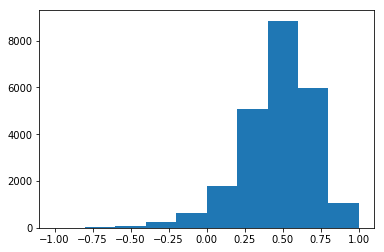

In [8]:
# look at a timegate to check the scaling
plt.hist(X[:,1,3,0].flatten())

In [9]:
def model(input_shape):

    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((3, 3))(X_input)
    
    # initializer to use
    initToUse=keras.initializers.glorot_normal(seed=0)
    #initToUse=keras.initializers.he_normal(seed=0)
    
    # for the leakly relu
    alphaParam=0.3

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (2, 3), strides = (1, 1), kernel_initializer=initToUse, name = 'conv0', padding='same')(X_input)
    X = MaxPooling2D((1, 2), name='max_pool0')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(32, (2, 5), strides = (1, 1), kernel_initializer=initToUse, name = 'conv1', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool1')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(64, (2, 7), strides = (1, 1), kernel_initializer=initToUse, name = 'conv2', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool2')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 9), strides = (1, 1), kernel_initializer=initToUse, name = 'conv3', padding='same')(X)
    X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    X = Conv2D(128, (2, 11), strides = (1, 1), kernel_initializer=initToUse, name = 'conv4', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool3')(X)
    X = keras.activations.relu(X,alpha=alphaParam)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool_final')(X)
    
    # make another initializer
    initToUse2=keras.initializers.he_normal(seed=0)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(200, activation='relu', kernel_initializer=initToUse2,name='fc0')(X)
    X = Dense(100, activation='relu', kernel_initializer=initToUse2,name='fc1')(X)
    X = Dense(50, activation='relu', kernel_initializer=initToUse2,name='fc2')(X)
    X = Dense(1, activation='sigmoid', kernel_initializer=initToUse,name='fc3')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    ### END CODE HERE ###
    
    return model

In [19]:
def modelv2(inputShape):

    model = keras.models.Sequential()
    
    # make the initializer
    initToUse=keras.initializers.glorot_normal(seed=0)
    initToUse2=keras.initializers.he_normal(seed=0)

    # for the leakly relu
    alphaParam=0.3
    
    # short dim
    shortDim=3
    
    # add some conv layers
    model.add(Conv2D(16, (shortDim, 3), input_shape=inputShape, kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(32, (shortDim, 5), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(64, (shortDim, 7), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (shortDim, 9), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    model.add(Conv2D(256, (shortDim, 11), kernel_initializer=initToUse, padding='same'))
    model.add(MaxPooling2D(pool_size=(1,2), strides=None))
    model.add(keras.layers.LeakyReLU(alpha=alphaParam))
    
    # flatten and do some dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu')) 
    model.add(Dense(160, activation='relu'))
    model.add(Dense(96, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # CONV -> BN -> RELU Block applied to X
    #X = Conv2D(16, (2, 3), strides = (1, 1), kernel_initializer=initToUse, name = 'conv0', padding='same')(X_input)
    #X = MaxPooling2D((1, 2), name='max_pool0')(X)
    #X = keras.activations.relu(X,alpha=alphaParam)
    #X = Conv2D(32, (2, 5), strides = (1, 1), kernel_initializer=initToUse, name = 'conv1', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool1')(X)
    #X = keras.activations.relu(X,alpha=alphaParam)
    #X = Conv2D(64, (2, 7), strides = (1, 1), kernel_initializer=initToUse, name = 'conv2', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool2')(X)
    #X = keras.activations.relu(X,alpha=alphaParam)
    #X = Conv2D(128, (2, 9), strides = (1, 1), kernel_initializer=initToUse, name = 'conv3', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool3')(X)
    #X = keras.activations.relu(X,alpha=alphaParam)
    #X = Conv2D(128, (2, 11), strides = (1, 1), kernel_initializer=initToUse, name = 'conv4', padding='same')(X)
    #X = MaxPooling2D((1, 2), name='max_pool3')(X)
    #X = keras.activations.relu(X,alpha=alphaParam)
    # input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
    # this applies 32 convolution filters of size 3x3 each.
    #model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    #model.add(Flatten())
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='softmax'))

    return model

In [8]:
# set epochs and everything
learningRate=0.0008
epochNum=300
#epochNum=100   # using shorter for faster training
batchSize=480  # best was 475 but 480 is a multiple of 32, fits in memory better?

adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=learningRate)
Model1 = modelv2(X_train.shape[1:] )
Model1.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
Model1.fit(x = X_train, y = Y_train, epochs = epochNum, batch_size = batchSize,  verbose=1)
Model1.evaluate(x = X_test, y = Y_test)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/300
20000/20000 [==============================] - 5s - loss: 0.6023 - acc: 0.7131     
Epoch 2/300
20000/20000 [==============================] - 0s - loss: 0.5642 - acc: 0.7328     
Epoch 3/300
20000/20000 [==============================] - 0s - loss: 0.5541 - acc: 0.7480     
Epoch 4/300
20000/20000 [==============================] - 0s - loss: 0.5423 - acc: 0.7569     
Epoch 5/300
20000/20000 [==============================] - 0s - loss: 0.5400 - acc: 0.7568     
Epoch 6/300
20000/20000 [==============================] - 0s - loss: 0.5318 - acc: 0.7594     
Epoch 7/300
20000/20000 [==============================] - 0s - loss: 0.5390 - acc: 0.7541     
Epoch 8/300
20000/20000 [==============================] - 0s - loss: 0.5240 - acc: 0.7654     
Epoch 9/300
20000/20000 [==============================] - 0s - loss: 0.5040 - acc: 0.

20000/20000 [==============================] - 0s - loss: 0.1941 - acc: 0.9186     
Epoch 162/300
20000/20000 [==============================] - 0s - loss: 0.1927 - acc: 0.9186     
Epoch 163/300
20000/20000 [==============================] - 0s - loss: 0.1884 - acc: 0.9209     
Epoch 164/300
20000/20000 [==============================] - 0s - loss: 0.1905 - acc: 0.9233     
Epoch 165/300
20000/20000 [==============================] - 0s - loss: 0.1885 - acc: 0.9219     
Epoch 166/300
20000/20000 [==============================] - 0s - loss: 0.1883 - acc: 0.9209     
Epoch 167/300
20000/20000 [==============================] - 0s - loss: 0.1866 - acc: 0.9218     
Epoch 168/300
20000/20000 [==============================] - 0s - loss: 0.1941 - acc: 0.9206     
Epoch 169/300
20000/20000 [==============================] - 0s - loss: 0.1946 - acc: 0.9193     
Epoch 170/300
20000/20000 [==============================] - 0s - loss: 0.1877 - acc: 0.9230     
Epoch 171/300
20000/20000 [=======

[0.8797060686857142, 0.8521276595744681]

In [20]:
# set epochs and everything
learningRate=0.0008
epochNum=250
#epochNum=100   # using shorter for faster training
batchSize=480  # best was 475 but 480 is a multiple of 32, fits in memory better?
adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=learningRate)
test_acc=np.zeros((5,1))

# make a list of models
ensembleSize=5
Models=[]

# train the ensemble of models
for i in range(ensembleSize):
    
    # make the model
    Models.append(modelv2(X_train.shape[1:] ))
    
    # compile the model
    Models[i].compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
 
    # fit the model
    Models[i].fit(x = X_train, y = Y_train, epochs = epochNum, batch_size = batchSize,  verbose=0)

    # predict
    temp=Models[i].evaluate(x = X_test, y = Y_test)
    test_acc[i]=temp[1]

test_acc_var=np.var(100*test_acc)

# get the mean label, round it and find the emsemble test acc
meanLabels=(Models[0].predict(X_test)+Models[1].predict(X_test)+Models[2].predict(X_test)+Models[3].predict(X_test)+Models[4].predict(X_test))/5
meanLabels=np.round(meanLabels)
wrongLabels=Y_test-meanLabels
test_acc_mean=1-np.sum(np.abs(wrongLabels))/len(Y_test)

print("\n Final ensemble test accuracy of: ",str(np.round(test_acc_mean*100,2)),", mean test accuracy of:",np.str(np.round(np.mean(test_acc)*100,2)),"with a std of: ",str(np.round(test_acc_var,2)))

3552/3760 [===========================>..] - ETA: 0s
 Final ensemble test accuracy of:  87.39 , mean test accuracy of: 84.41 with a std of:  0.61


In [21]:
# xavier init for the convs got 87%, trying he instead, got 85, do xavier I guess

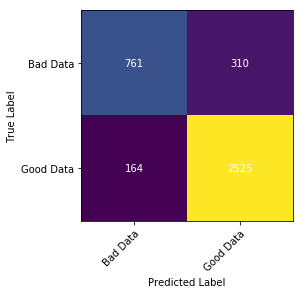

In [22]:
dataClasses = ["Bad Data","Good Data"]


confusionMat = sklearn.metrics.confusion_matrix(Y_test,meanLabels)

fig, ax = plt.subplots()
im = ax.imshow(confusionMat)

# We want to show all ticks...
ax.set_xticks(np.arange(len(dataClasses)))
ax.set_yticks(np.arange(len(dataClasses)))
# ... and label them with the respective list entries
ax.set_xticklabels(dataClasses)
ax.set_yticklabels(dataClasses)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dataClasses)):
    for j in range(len(dataClasses)):
        text = ax.text(j, i, confusionMat[i, j],
                       ha="center", va="center", color="w")

#x.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()  

In [ ]:
# hyper paramater tuning, currently just set up for learning rate, batch size and # of epochs

# values already tried, Feb 19th
#lr_array=np.array([0.1,0.05,0.01,0.005,0.001])
#batch_size_array=np.array([16,32,64,128,256,512,1024])
#epoch_array=np.array([10,20,40,80,160])

# set the arrays Feb 19th, best train acc was at 0.0008 200 450, best test was at 0.0008 160 450
#lr_array=np.array([0.005,0.003,0.001,0.0008,0.0005,0.0001])
#batch_size_array=np.array([400,450,500,512,550])
#epoch_array=np.array([100,130,160,180,200])

# set the arrays, best test acc was 85%, train acc of 97% at 0.0008 250 475 (got to 100% train acc with longer train time, 500 epochs)
lr_array=np.array([0.0009,0.0008,0.0007,0.0006])
batch_size_array=np.array([425,450,475])
epoch_array=np.array([160,170,250,500])


# get their sizes and their final size
lr_array_size=np.shape(lr_array)[0]
batch_size_array_size=np.shape(batch_size_array)[0]
epoch_array_size=np.shape(epoch_array)[0]
final_size=lr_array_size*batch_size_array_size*epoch_array_size

# tile and reshape them
lr_array=np.tile(lr_array,final_size).squeeze()
batch_size_array=np.reshape(np.tile(np.tile(batch_size_array,(lr_array_size,1)).T,(epoch_array_size,1)),[final_size,1]).squeeze()
epoch_array=np.reshape(np.tile(epoch_array,(lr_array_size*batch_size_array_size,1)).T,[1,final_size]).squeeze()

# make lists and arrays for the results
training_history=[]
training_history_acc=np.zeros((final_size,1))
preds_history=[]
preds_loss=np.zeros((final_size,1))
preds_acc=np.zeros((final_size,1))

# loop de loop
for i in range(final_size):
    
    # make the model and its opimizer
    happyModel = model(X_train.shape[1:] )
    adam=keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,lr=lr_array[i])
    
    # compile the model
    happyModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])
    
    # fit the model
    temp=happyModel.fit(x = X_train, y = Y_train, epochs = np.int(epoch_array[i]), batch_size = np.int(batch_size_array[i]),  verbose=0)
    
    # store how it did
    training_history_acc[i]=temp.history['acc'][-1]
    training_history.append(temp)
    
    # predict and store on x_test
    temp=happyModel.evaluate(x = X_test, y = Y_test)
    preds_loss[i]=temp[0]
    preds_acc[i]=temp[1]
    preds_history.append(temp)
    
    # print a msg
    print(" Training accuracy = "+str(np.round(training_history_acc[i]*100,2))+"%, learning rate, epoch size, and mini-batch size: "+str(lr_array[i])+","+str(epoch_array[i])+","+str(batch_size_array[i])+", test loss and accuracy: "+str(preds_loss[i])+str(np.round(preds_acc[i]*100,2))+"%")

In [190]:
# current best is lr=0.0008, epochs=250, batch size=475, gives 97.4% train and 85.5% test

[4.456235956638418, 0.7204787234042553]

In [39]:
best=np.argmax(preds_acc)
print(np.max(preds_acc),lr_array[best],epoch_array[best],batch_size_array[best])

0.8550531914893617 0.0008 250 475


In [40]:
best=np.argmax(training_history_acc)
print(np.max(training_history_acc),lr_array[best],epoch_array[best],batch_size_array[best])

1.0 0.0009 500 425


In [96]:
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(x = X_test, y = Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3680/3760 [============================>.] - ETA: 0s
Loss = 0.4233942541670292
Test Accuracy = 0.8236702127659574


In [23]:
Models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 3, 37, 16)         304       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 3, 18, 16)         0         
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 3, 18, 16)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 3, 18, 32)         7712      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 3, 9, 32)          0         
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 3, 9, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 3, 9, 64)          43072     
__________

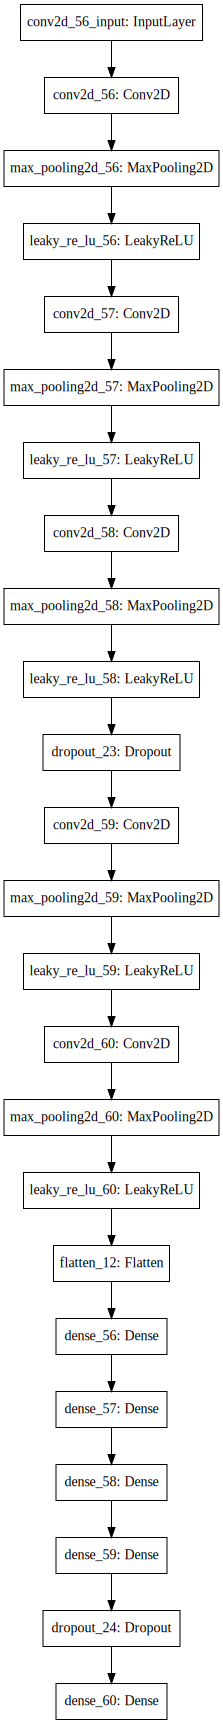

In [24]:
plot_model(Models[0], to_file='Model_graph.png')
SVG(model_to_dot(Models[0]).create(prog='dot', format='svg'))